Starting with the _imports_ :

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


In [9]:
%matplotlib inline

Initial _function_ definitions:

1. W_init

In [10]:
def W_init( shape, dtype = None ): # dtype here was "name" instead in the orig. code
    """Initialize weights as in paper"""
    values = rng.normal( loc=0, scale=1e-2, size=shape )
    return K.variable( values, dtype=dtype )

2. b_init

In [11]:
def b_init( shape, dtype = None ):
    """Initialize bias as in paper"""
    values = rng.normal( loc=0.5, scale=1e-2, size=shape )
    return K.variable( values, dtype=dtype )

Image size:

In [12]:
input_shape = (105, 105, 1)

## Building the first part of convnet :

![Siamese network for one-shot learning of _Omniglot_ data displayed in the paper](images/convnet.png)

In [28]:
# build convnet to use in each siamese 'leg'
convnet = Sequential([
    # 1st Conv. Layer
    Conv2D( 64, (10,10), 
             activation='relu', 
             input_shape=input_shape,
             kernel_initializer=W_init, 
             kernel_regularizer=l2(2e-4) ),
    MaxPooling2D(),
    # 2nd Conv. Layer
    Conv2D( 128, (7,7), 
             activation='relu',
             kernel_initializer=W_init,
             kernel_regularizer=l2(2e-4),
             bias_initializer=b_init ),
    MaxPooling2D(),
    # 3rd Conv. Layer
    Conv2D( 128, (4,4),
             activation='relu',
             kernel_initializer=W_init,
             kernel_regularizer=l2(2e-4),
             bias_initializer=b_init ),
    MaxPooling2D(),
    # 4th Conv. Layer
    Conv2D( 256, (4,4),
             activation='relu',
             kernel_initializer=W_init,
             kernel_regularizer=l2(2e-4),
             bias_initializer=b_init ),
    # Flattening
    Flatten(),
    # Full connection
    Dense( 4096,
            activation="sigmoid",
            kernel_initializer=W_init,
            kernel_regularizer=l2(1e-3),
            bias_initializer=b_init )
])
convnet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 256)        

## Entering the Siamese part in convnet

In [23]:
left_input = Input(input_shape)
right_input = Input(input_shape)

# call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [24]:
# layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

In [25]:
# call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [26]:
optimizer = Adam( 0.00006 )
siamese_net.compile( loss="binary_crossentropy", optimizer=optimizer ) # Uses optimizer Adam here.
siamese_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

<img src="images/siamese.png" title="Siamese network architecture" align="left" width="40%" height="40%">

## Data

The data is pickled as an _N-classes x n-examples x width x height_ array, and there is an accompanying dictionary to specify which indexes belong to which languages.

In [3]:
PATH = "" # FILL THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print( "Training alphabets:\n{}".format( c.keys() ) )
print( "\nValidation alphabets:\n{}".format( cval.keys() ) )

Training alphabets:
dict_keys(['Syriac_(Estrangelo)', 'Arcadian', 'Cyrillic', 'Alphabet_of_the_Magi', 'Bengali', 'Malay_(Jawi_-_Arabic)', 'Tagalog', 'Greek', 'Japanese_(katakana)', 'Gujarati', 'Mkhedruli_(Georgian)', 'Tifinagh', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Hebrew', 'Armenian', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Early_Aramaic', 'N_Ko', 'Korean', 'Sanskrit', 'Braille', 'Balinese', 'Futurama', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Asomtavruli_(Georgian)', 'Japanese_(hiragana)', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Latin', 'Grantha'])

Validation alphabets:
dict_keys(['Glagolitic', 'Tengwar', 'Kannada', 'Manipuri', 'Avesta', 'Ge_ez', 'ULOG', 'Malayalam', 'Angelic', 'Syriac_(Serto)', 'Mongolian', 'Gurmukhi', 'Old_Church_Slavonic_(Cyrillic)', 'Aurek-Besh', 'Tibetan', 'Keble', 'Oriya', 'Atlantean', 'Sylheti', 'Atemayar_Qelisayer'])


## Class - Siamese Loader

In [4]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task( self, N, s="val", language=None ):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        # print(X.shape) # shape created a problem due to opencv's imread turning 3 channel instead of 1
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)    
        else: #if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)
            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train( self, model, epochs, verbosity ):
        model.fit_generator( self.generate(batch_size), )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

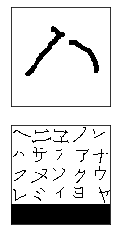

In [22]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task( pairs )

## Towards Training and Testing

In [23]:
#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 100 #90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how many one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training starts...")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print( "i{}) {} loss".format(i, loss) )
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path) # Save the weights
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

!
training
1) 4.494691371917725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 19.2% 20 way one-shot learning accuracy
saving
2) 4.444308280944824
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.0% 20 way one-shot learning accuracy
saving
3) 4.417568206787109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 27.6% 20 way one-shot learning accuracy
saving
4) 4.418460845947266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 30.8% 20 way one-shot learning accuracy
saving
5) 4.395270824432373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.6% 20 way one-shot learning accuracy
6) 4.369663238525391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.8% 20 way one-shot learning accuracy
7) 4.3838653564453125
eva

53) 3.5748488903045654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.0% 20 way one-shot learning accuracy
54) 3.606478214263916
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 24.4% 20 way one-shot learning accuracy
55) 3.607285737991333
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 20.0% 20 way one-shot learning accuracy
56) 3.5654990673065186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.2% 20 way one-shot learning accuracy
57) 3.464522361755371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 27.6% 20 way one-shot learning accuracy
58) 3.4277024269104004
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 15.2% 20 way one-shot learning accuracy
59) 3.5517008304595947
evaluating
Evaluating model on 2

In [32]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [26]:
ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 5 #450

for N in ways:
    print( "(i{})".format(N) ) # prints iteration N
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))

(i1)
Evaluating model on 5 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 5 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 1 way one-shot learning tasks ...
(i3)
Evaluating model on 5 random 3 way one-shot learning tasks ...
Got an average of 80.0% 3 way one-shot learning accuracy
Evaluating model on 5 random 3 way one-shot learning tasks ...
Got an average of 40.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 3 way one-shot learning tasks ...
(i5)
Evaluating model on 5 random 5 way one-shot learning tasks ...
Got an average of 40.0% 5 way one-shot learning accuracy
Evaluating model on 5 random 5 way one-shot learning tasks ...
Got an average of 80.0% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 5 way one-shot learning tasks ...
(i7)
Evaluating model on 5 random 7 wa

Got an average of 20.0% 51 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 51 way one-shot learning tasks ...
(i53)
Evaluating model on 5 random 53 way one-shot learning tasks ...
Got an average of 0.0% 53 way one-shot learning accuracy
Evaluating model on 5 random 53 way one-shot learning tasks ...
Got an average of 0.0% 53 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 53 way one-shot learning tasks ...
(i55)
Evaluating model on 5 random 55 way one-shot learning tasks ...
Got an average of 0.0% 55 way one-shot learning accuracy
Evaluating model on 5 random 55 way one-shot learning tasks ...
Got an average of 0.0% 55 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 55 way one-shot learning tasks ...
(i57)
Evaluating model on 5 random 57 way one-shot learning tasks ...
Got an average of 0.0% 57 way one-shot learning accuracy
Evaluating model on 5 random 57 way one-shot learning tasks ...
Got an average of 20.0% 57 

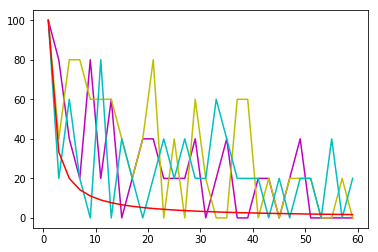

In [27]:
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

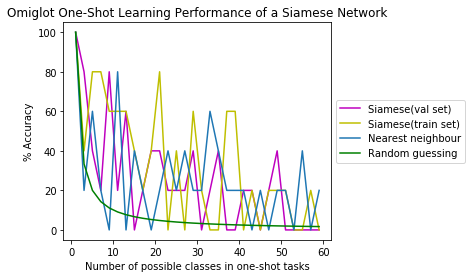

(20, 105, 105, 1)


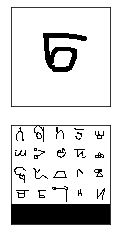

[[0.2634513 ]
 [0.31165445]
 [0.21685305]
 [0.44387776]
 [0.53946984]
 [0.43996435]
 [0.3278433 ]
 [0.51064515]
 [0.6989372 ]
 [0.61155427]
 [0.58040667]
 [0.34905076]
 [0.10100135]
 [0.01936793]
 [0.52588373]
 [0.5622124 ]
 [0.5222802 ]
 [0.01386795]
 [0.24292164]
 [0.6117814 ]]


In [28]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [34]:
a=test_nn_accuracy(3,500,loader)
print( "{}%".format(a) )

Evaluating nearest neighbour on 500 unique 3 way one-shot learning tasks ...
55.8%
